In [1]:
import random
random.seed(0)

import numpy as np
np.random.seed

import tensorflow as tf
tf.random.set_seed(0)

In [2]:
import os
import json
import shutil
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [3]:
kaggle_credentials = json.load(open('kaggle.json'))

In [4]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [5]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 97% 657M/675M [00:07<00:00, 160MB/s]
100% 675M/675M [00:07<00:00, 94.6MB/s]


In [6]:
with ZipFile('cell-images-for-detecting-malaria.zip', 'r') as zip_ref:
  zip_ref.extractall()

In [7]:
print(os.listdir('/content/cell_images'))

print(len(os.listdir("/content/cell_images/Parasitized")))
print(os.listdir("/content/cell_images/Parasitized")[:5])

print(len(os.listdir("/content/cell_images/Uninfected")))
print(os.listdir("/content/cell_images/Uninfected")[:5])

print(len(os.listdir("/content/cell_images/cell_images")))
print(os.listdir("/content/cell_images/cell_images")[:5])

['Parasitized', 'cell_images', 'Uninfected']
13780
['C74P35_ThinF_IMG_20150815_121324_cell_138.png', 'C118P79ThinF_IMG_20151002_105735_cell_152.png', 'C182P143NThinF_IMG_20151201_171950_cell_169.png', 'C136P97ThinF_IMG_20151005_141946_cell_100.png', 'C181P142ThinF_IMG_20151127_155914_cell_162.png']
13780
['C149P110ThinF_IMG_20151115_114555_cell_8.png', 'C93P54ThinF_IMG_20150821_163815_cell_149.png', 'C212ThinF_IMG_20151106_105437_cell_183.png', 'C89P50ThinF_IMG_20150820_162300_cell_21.png', 'C125P86ThinF_IMG_20151004_101158_cell_28.png']
2
['Parasitized', 'Uninfected']


In [8]:
image_path = "/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png"
picture = mping.imread(image_path)
print(picture.shape)
picture

(148, 142, 3)


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

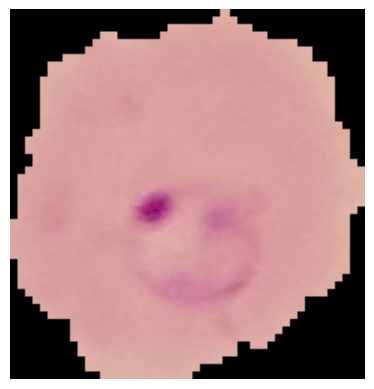

In [9]:
plt.imshow(picture)
plt.axis('off')
plt.show()

In [10]:
base_directory = "/content/cell_images/cell_images"

In [11]:
# Creating directories for train and validation splits
train_dir = os.path.join(base_directory, 'train')
validation_dir = os.path.join(base_directory, 'validation')

In [12]:
# Ensuring the directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [13]:
# Defining subdirectories for Infected and Uninfected cells
infected_dir = os.path.join(base_directory, 'Parasitized')
uninfected_dir = os.path.join(base_directory, 'Uninfected')

In [14]:
train_infected_dir = os.path.join(train_dir, 'Parasitized')
train_uninfected_dir = os.path.join(train_dir, 'Uninfected')
validation_infected_dir = os.path.join(validation_dir, 'Parasitized')
validation_uninfected_dir = os.path.join(validation_dir, 'Uninfected')

In [15]:
os.makedirs(train_infected_dir, exist_ok=True)
os.makedirs(train_uninfected_dir, exist_ok=True)
os.makedirs(validation_infected_dir, exist_ok=True)
os.makedirs(validation_uninfected_dir, exist_ok=True)

In [16]:
split_ratio = 0.8

In [17]:
def split_data(source_dir, train_dir, validation_dir, split_ratio):
    files = os.listdir(source_dir)
    random.shuffle(files)
    split_point = int(len(files) * split_ratio)
    train_files = files[:split_point]
    validation_files = files[split_point:]

    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))
    for file in validation_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(validation_dir, file))

In [18]:
split_data(infected_dir, train_infected_dir, validation_infected_dir, split_ratio)
split_data(uninfected_dir, train_uninfected_dir, validation_uninfected_dir, split_ratio)

In [19]:
image_size = 135
batch_size = 32

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

In [21]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [22]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary'
)

Found 22046 images belonging to 2 classes.


In [23]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary'
)

Found 5512 images belonging to 2 classes.


In [24]:
# Building the model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Using Sigmoid for binary classification

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 133, 133, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 66, 66, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 128)       0

In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10
688/688 [==============================] - 1098s 2s/step - loss: 0.3302 - accuracy: 0.8488 - val_loss: 0.1836 - val_accuracy: 0.9373
Epoch 2/10
688/688 [==============================] - 1098s 2s/step - loss: 0.1443 - accuracy: 0.9544 - val_loss: 0.1373 - val_accuracy: 0.9566
Epoch 3/10
688/688 [==============================] - 1111s 2s/step - loss: 0.1157 - accuracy: 0.9621 - val_loss: 0.1415 - val_accuracy: 0.9569
Epoch 4/10
688/688 [==============================] - 1092s 2s/step - loss: 0.0955 - accuracy: 0.9672 - val_loss: 0.1492 - val_accuracy: 0.9499
Epoch 5/10
688/688 [==============================] - 1086s 2s/step - loss: 0.0695 - accuracy: 0.9764 - val_loss: 0.1804 - val_accuracy: 0.9517
Epoch 6/10
688/688 [==============================] - 1081s 2s/step - loss: 0.0440 - accuracy: 0.9852 - val_loss: 0.2617 - val_accuracy: 0.9528
Epoch 7/10
688/688 [==============================] - 1082s 2s/step - loss: 0.0337 - accuracy: 0.9881 - val_loss: 0.2510 - val_accuracy:

In [28]:
val_loss, val_accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

172/172 [==============================] - 71s 413ms/step - loss: 0.3482 - accuracy: 0.9499
Validation Accuracy: 94.99%


In [36]:
def load_and_preprocess_image(image_path, target_size=(135, 135)):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image_array = np.array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array.astype('float32') / 255.
    return image_array

In [32]:
def predict_image_class(model, image_path):
    preprocessed_image = load_and_preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    return 'Infected' if prediction[0] > 0.5 else 'Uninfected'

In [33]:
image_path = '/content/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'
predicted_class_name = predict_image_class(model, image_path)
print('Predicted Class Name:', predicted_class_name)

1/1 [==============================] - 0s 304ms/step
Predicted Class Name: Uninfected


In [ ]:
model.save('Malaria_Detection_Model.h5')